In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [86]:
import tensorflow as tf
from tensorflow.keras import layers , models
import numpy as np
import matplotlib.pyplot as plt

In [55]:
IMAGE_SIZE = 255
BATCH_SIZE = 32
CHANNEL = 3
EPOCHS = 10

In [56]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/training/potato",
    shuffle = True,
    image_size = (IMAGE_SIZE , IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [59]:
classes = ds.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [63]:
train_size = np.floor(len(ds) * 0.8)
train_ds = ds.take(train_size)

In [68]:
val_size = np.floor(len(ds)*0.1)
val_ds = ds.skip(train_size).take(val_size)

test_ds = ds.skip(train_size).skip(val_size)

In [69]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [70]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE , IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [71]:
augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [73]:
train_ds = train_ds.map(
    lambda x , y : (augmentation(x , training = True) , y)
).prefetch(buffer_size = tf.data.AUTOTUNE)

In [78]:
INPUT_SHAPE = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNEL)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    augmentation,
    layers.Conv2D(32 , kernel_size = (3,3) , activation = 'relu' , input_shape = INPUT_SHAPE),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , kernel_size = (3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , kernel_size = (3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , kernel_size = (3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , kernel_size = (3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , kernel_size = (3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64 , activation = 'relu'),
    layers.Dense(n_classes , activation = 'softmax')
])

model.build(input_shape = INPUT_SHAPE)

In [79]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 255, 255, 3)         0         
                                                                 
 sequential_4 (Sequential)   (None, 255, 255, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 253, 253, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 126, 126, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [84]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [85]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 254s 4s/step - loss: 0.8663 - accuracy: 0.5793 - val_loss: 0.6896 - val_accuracy: 0.7760
Epoch 2/10
54/54 [==============================] - 236s 4s/step - loss: 0.5492 - accuracy: 0.7749 - val_loss: 0.5809 - val_accuracy: 0.7552
Epoch 3/10
54/54 [==============================] - 239s 4s/step - loss: 0.4155 - accuracy: 0.8275 - val_loss: 0.3055 - val_accuracy: 0.8646
Epoch 4/10
54/54 [==============================] - 230s 4s/step - loss: 0.3031 - accuracy: 0.8704 - val_loss: 0.2452 - val_accuracy: 0.8906
Epoch 5/10
54/54 [==============================] - 260s 5s/step - loss: 0.2770 - accuracy: 0.8866 - val_loss: 0.2953 - val_accuracy: 0.8594
Epoch 6/10
54/54 [==============================] - 250s 5s/step - loss: 0.2142 - accuracy: 0.9057 - val_loss: 0.1725 - val_accuracy: 0.9271
Epoch 7/10
54/54 [==============================] - 236s 4s/step - loss: 0.1905 - accuracy: 0.9230 - val_loss: 0.1865 - val_accuracy: 0.9167
Epoch 8/10
54

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 234ms/step
predicted label: Potato___Late_blight


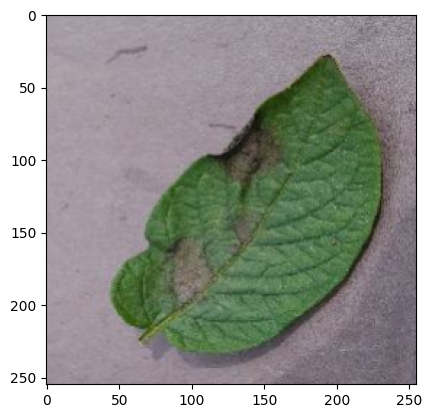

In [91]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])